# 一、化学特征和药效团提取
Rdkit中有一系列基于SMARTS定义的化学特征。要对分子进行化学特征分析和计算时，需要先导入一个特征库，创建一个特征工厂，并通过特征工厂计算化学特征。先来操作一下，原理及介绍在第二部分。
* 获取特征库：RDConfig.RDDataDir目录下的'BaseFeatures.fdef'
* 构建特征工厂：ChemicalFeatures.BuildFeatureFactory(fdefName)<br />
fdefName：特征库文件

In [1]:
from rdkit import Chem
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
import os
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
factory = ChemicalFeatures.BuildFeatureFactory(fdefName)

* 使用特征工厂搜索特征：GetFeaturesForMol(m)

8


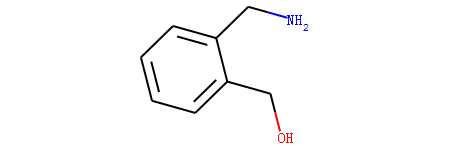

In [2]:
m = Chem.MolFromSmiles('OCc1ccccc1CN')
feats = factory.GetFeaturesForMol(m)
print(len(feats))
m

搜索到的每个特征都包含了该特征家族（例如供体、受体等）、特征类别、该特征对应的原子、特征对应序号等信息。
* 特征家族信息：GetFamily()
* 特征类型信息：GetType()
* 特征对应原子：GetAtomIds()
* 特征对应序号：GetId()

In [3]:
print(feats[0].GetFamily())
print(feats[0].GetType())
print(feats[0].GetAtomIds())

Donor
SingleAtomDonor
(0,)


* 如果分子包含坐标信息，化学特征也会包括原子坐标：GetPos()

In [4]:
from rdkit.Chem import AllChem
AllChem.Compute2DCoords(m)
list(feats[0].GetPos())

[2.0705367611607857, -2.335674960409047, 0.0]

# 二、化学特征文件介绍
以上都是基于现有的特征库进行分析和提取，而特征库就是一个特征定义文件（Feature Definition File, FDef）。该文件包含了一系列的化学特征及它们的所有信息，并通过SMARTS来表示。除了化学特征，FDef文件也有对原子类型的定义及解释，让特征更容易理解。
* 对特征感兴趣的可以打印一下该FDef文件

In [ ]:
with open(fdefName) as f:
    file = f.read()
print(file)

* 每个化学特征对应的SMARTS，对SMARTS不了解的可以[参考这份速查表](https://blog.csdn.net/dreadlesss/article/details/105739826)<br />
key为“特征家族.特征类型”，值为SMARTS

In [5]:
list(factory.GetFeatureDefs().items())[:2]

[('Donor.SingleAtomDonor',
  '[$([N&!H0&v3,N&!H0&+1&v4,n&H1&+0,$([$([Nv3](-C)(-C)-C)]),$([$(n[n;H1]),$(nc[n;H1])])]),$([O,S;H1;+0])]'),
 ('Acceptor.SingleAtomAcceptor',
  '[$([O;H1;v2]),$([O;H0;v2;!$(O=N-*),$([O;-;!$(*-N=O)]),$([o;+0])]),$([n;+0;!X3;!$([n;H1](cc)cc),$([$([N;H0]#[C&v4])]),$([N&v3;H0;$(Nc)])]),$([F;$(F-[#6]);!$(FC[F,Cl,Br,I])])]')]

## 1.化学特征（chemical features）
化学特征由一个特征类型（Feature Type）和特征家族（Feature Family）共同定义。特征家族是对特征总体上的分类，例如氢键供体、芳香性等。药效团匹配就是根据特征家族来实现的。而特征类型提供了关于特征的一些更详细的信息。每个特征类型包含了以下信息：
 - 一个SMARTS表达式，定义了该特征类型所匹配的原子。
 - 特征位置的权重，特征位置由原子位置决定。

## 2.FDef文件语法
FDef中包含两个概念：原子类型和特征。可以大致这么认为：原子类型是最底层的抽象，对相似的原子做了归类。特征是更高级的抽象，对相似的原子和原子类型再进行归类。以下都围绕原子类型定义和特征定义的语法展开。[原文在这里](http://www.rdkit.org/docs/RDKit_Book.html#the-feature-definition-file-format)

**（1）原子类型（AtomType）定义**

* 原子类型定义相当于给用于查询原子的SMARTS起了一个别名，可以让FDef更具可读性。例如，可以用如下方式定义一个非极性碳原子，Carbon_NonPolar就是一个原子类型定义名称：<br />
AtomType Carbon_NonPolar [C&!$(C=[O,N,P,S])]<br />

* 因此，可以创建一个有利于理解和使用SMARTS的名称。要引用某个原子类型，可以写下该名称并用大括号括起来。例如，定义另一个原子类型，取名为Hphobe，让Hphobe包含Carbon_NonPolar：<br />
AtomType Carbon_NonPolar [C&!$(C=[O,N,P,S])]<br />
AtomType Hphobe [{Carbon_NonPolar},c,s,S&H0&v2,F,Cl,Br,I]<br />

* 重复写下一个原子类型时，意味着把他们合在一起，相当于用“,”连接（在SMARTS中表示或），例如下面两个语句：<br />
AtomType d1 [N&!H0]<br />
AtomType d1 [O&!H0]<br >
* 等价于：<br />
AtomType d1 [N&!H0,O&!H0]<br />
* 更简洁的写法：<br />
AtomType d1 [N,O;!H0]<br />
* 要注意“&”和“;”都表示“与”，“,”表示“或”，但“&”的优先级高于“,”，而“;”的优先级低于“,”。<br />
* 类似与SMARTS，原子特征定义也可以用“!”来表示非，而“!”会与自身的表达式结合，例如：<br />
AtomType d1 [N,O,S]<br />
AtomType !d1 [H0]<br />
* “!d1”等价于：<br />
AtomType d1 [!H0;N,O,S]<br />

**（2）特征（Feature）定义**

* 特征定义比原子类型定义更复杂，并且需要多行实现，例如：<br />
DefineFeature HDonor1 [N,O;!H0]<br />
Family HBondDonor<br />
Weights 1.0<br />
EndFeature<br />

* 特征定义的第一行包含了特征类型和所规定的SMARTS，第二行和第三行（没有先后顺序）定义了特征家族和原子权重（权重值的数量和SMARTS中包含的原子数量相同，有多个权重时，用逗号分隔）。原子权重用来计算特征的位置。最后一行表示结束定义，必须是“EndFeature”。原子类型定义和特征定义可以混在一起使用，只要在引用前定义好就行了。

**（3）其它语法**
 - 井号“#”开头表示注释，程序运行时会忽略该行。
 - 反斜杠“\”结尾表示续行，也就是该行没有结束。
 - 开头的空格将被忽略。

# 三、2D药效团指纹

## 1.编码原理
对2D药效团的解释如下图。这里做一个简单的解释。2D药效团指纹，是在药效团的基础上，加上2D（拓扑）距离实现。当在药效团间加入了距离信息后，每个特征（药效团+距离）会被分配一个唯一的id，所有的id共同组成了分子的2D药效团指纹。指纹生成过程中，有两个关键参数，第一个是组成指纹的药效团数量，需要提供最少和最多药效团数。下图中的“2-3 point pharmacophores”表示一个指纹特征中，最少包括2个，最多包括3个药效团。第二个关键参数是拓扑距离区间，用于对两个药效团间的距离进行归类，对应下图的“distance bins”。根据药效团组成和距离的不同，形成不同的bit id。在Rdkit的体系中，药效团指纹的bit ids是没有经过哈希映射的，也就是说，指纹的每一位都代表了一组特征和它们的距离。所以，给定一个bit id，可以推出它对应的特征类型和距离，可以方便地对结果进行解释。

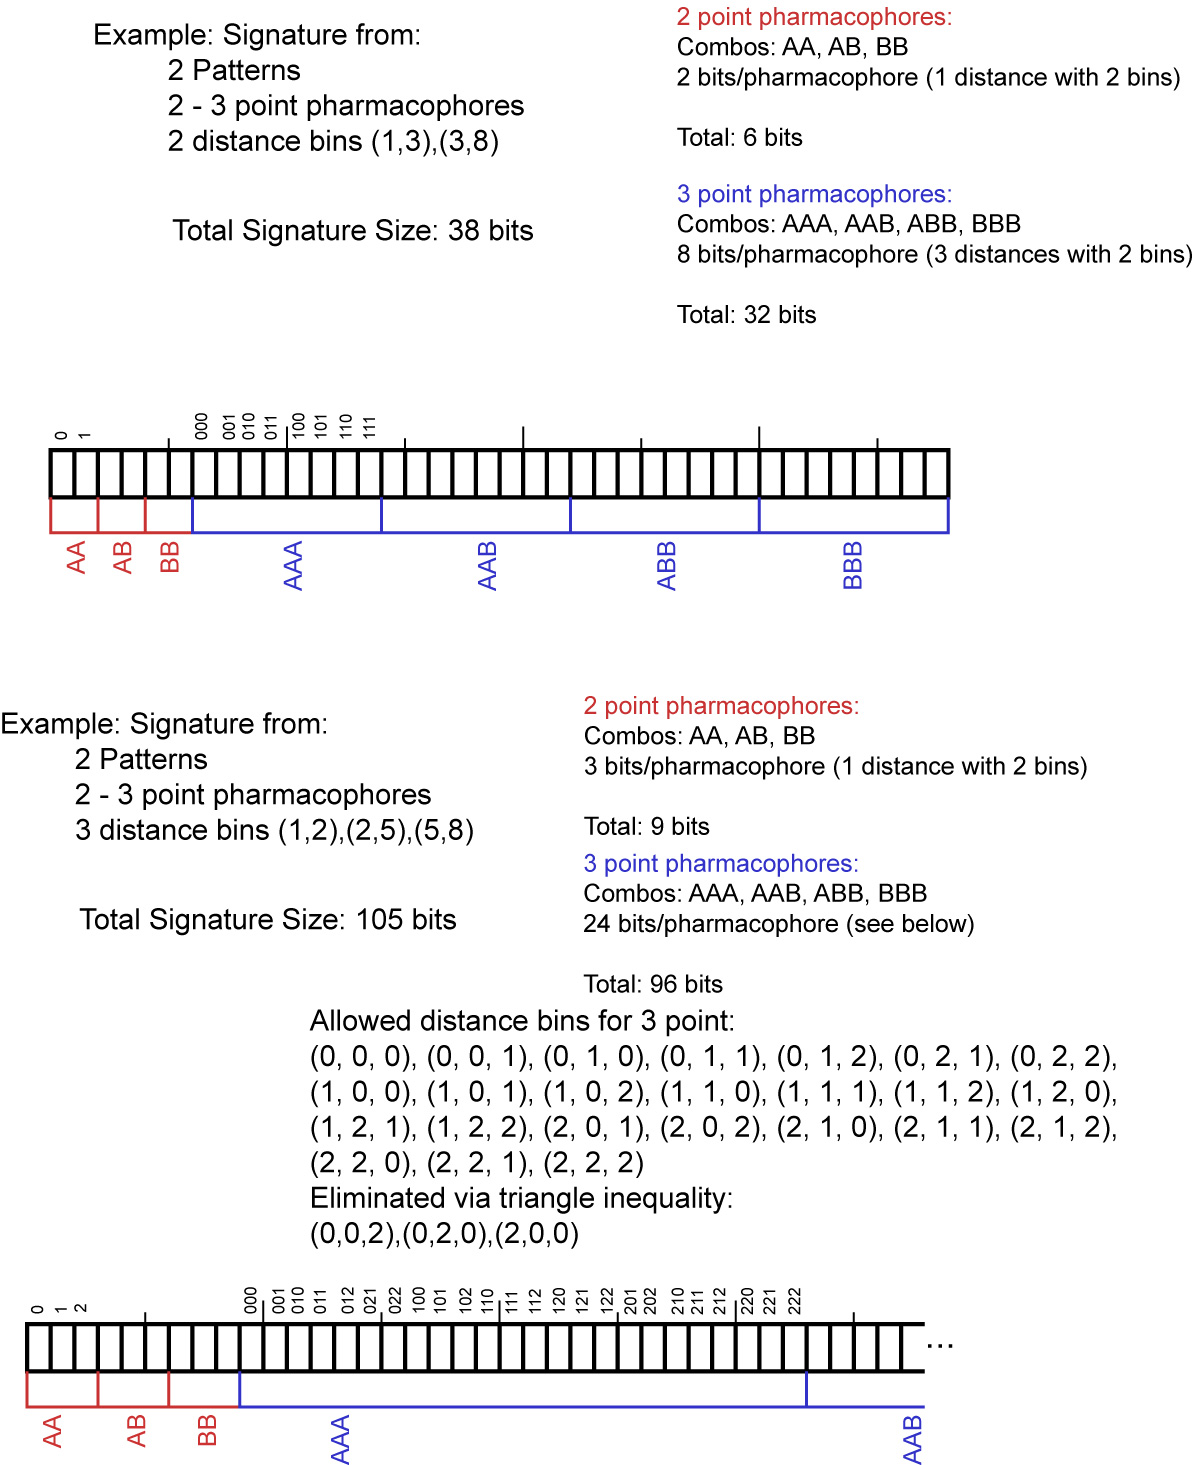

In [6]:
from IPython.display import Image
Image(filename = 'data/bit_in_pharmacophore_fp.jpg', width=650)

## 2.参数设置
生成药效团指纹首先要计算分子中所有的药效团（化学特征），化学特征的计算需要通过特征工厂实现。
* 构建特征工厂：

In [7]:
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefName)

使用特征工厂再来构建指纹工厂signature factory用于设置指纹参数。
* 构建指纹工厂：SigFactory(featFactory, useCounts=False, minPointCount=2, maxPointCount=3, ...)<br />
featFactory：特征工厂<br />
useCounts：默认False。False不考虑指纹频数，并生成SparseBitVect<br />
minPointCount：默认为2。生成指纹时包括的最少的药效团数量<br />
maxPointCount：默认为3。生成指纹时包括的最多的药效团数量

In [8]:
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
sigFactory = SigFactory(featFactory, minPointCount=2, maxPointCount=3)

* 对拓扑距离进行分段：SetBins()
* 每次修改参数后，都要初始化一下：Init()
* 计算一下的指纹长度：GetSigSize()

In [9]:
sigFactory.SetBins([(0,2), (2,5), (5,8)])
sigFactory.Init()
sigFactory.GetSigSize()

2988

## 3.生成2D药效团指纹
指纹工厂中的参数设置完毕，接下来可以生成2D指纹了
* 计算2D药效团指纹：Gen2DFingerprint(mol, sigFactory, bitInfo, ...)<br />
mol：要计算指纹的mol对象<br />
sigFactory：设置了参数的指纹工厂<br />
bitInfo：获取指纹id及对应原子

In [10]:
from rdkit.Chem.Pharm2D import Generate
mol = Chem.MolFromSmiles('OCC(=O)CCCN')
fp = Generate.Gen2DFingerprint(mol,sigFactory)
print(len(fp))
print(fp.GetNumOnBits())

2988
23


* 关于指纹每一位所代表特征的信息、特征的距离矩阵等信息，都可以通过signature factory来查看

In [11]:
list(fp.GetOnBits())[:5]

[1, 7, 8, 10, 20]

In [12]:
sigFactory.GetBitDescription(1)

'Acceptor Acceptor |0 1|1 0|'

## 4.修改FDef设置
如果不想要某个特征，可以直接通过signature factory来跳过某个特征，而不用去修改FDef文件。
* 查看现有的药效团（特征家族）列表：GetFeatureFamilies()

In [13]:
featFactory.GetFeatureFamilies()

('Donor',
 'Acceptor',
 'NegIonizable',
 'PosIonizable',
 'ZnBinder',
 'Aromatic',
 'Hydrophobe',
 'LumpedHydrophobe')

* 跳过某个药效团（特征家族）：sigFactory.skipFeats
* 每次修改都要初始化一下：Inint()
* 再查看一下指纹长度：GetSigSize()

In [14]:
sigFactory.skipFeats=['PosIonizable']
sigFactory.Init()
sigFactory.GetSigSize()

2100

* 重新生成新的指纹：Gen2DFingerprint()

In [15]:
fp2 = Generate.Gen2DFingerprint(mol,sigFactory)
fp2.GetNumOnBits()

15

## 5.Gobbi 2D药效团指纹
Rdkit中还有一种用于生成2D药效团指纹的特征定义方式，根据Gobbi等人的设计实现，在 rdkit.Chem.Pharm2D.Gobbi_Pharm2D下有一个预定义的signature factory，已经包含了这些指纹类型，可以直接调用，操作方法类似。

In [16]:
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D, Generate
m = Chem.MolFromSmiles('OCC=CC(=O)O')
fp = Generate.Gen2DFingerprint(m, Gobbi_Pharm2D.factory)
fp.GetNumOnBits()

8

In [17]:
list(fp.GetOnBits())

[23, 30, 150, 154, 157, 185, 28878, 30184]

In [18]:
Gobbi_Pharm2D.factory.GetBitDescription(157)

'HA HD |0 3|3 0|'